## Fraud Detection 
This notebook will attempt to build a predictive algorithm to detect a fraudulent transaction using a training dataset. We will explain the thinking process at every step using LIME (Local Interpretable Model-agnostic Explanations) principles making it accessible and user-friendly.


# Table of Contents
1. Environment set-up
    * Importing Libraries
    * Loading the data
2. Initial Diagnostics
    * Glimpse
    * Descriptive Statitics
    * Target Variable Analysis
    * Predictors Analysis
3. Data Cleaning
    * Missing Values
    * Outliers
    * Duplicate Observations
4. Correlation Analysis
    * Correlation Matrix
    * Strongest relationship
5. Inquiry Exploration
    * How does Amount's distribution behaves across classes?
    * Are there any noteworthy point in time where fraud occured?
6. Class Imbalance 
    * SMOTE - Synthetic Minority Oversampling Technique
    * Near-Miss Algorithm
    * Combined Random Sampler
7. Machine Learning set-up
    * Train-test split
    * Cross-validation
8. Dimensionality Reduction
    * PCA - Principal Component Analysis
    * SVD - Singular Value Decomposition
    * LDA - Linear Discriminant Analysis
9. Machine Learning - Simple Models
    * Logistic Regression
    * k-Nearest Neighbors
    * Decision Tree
    * Stochastic Gradient Descent
10. Machine Learning - Ensemble Methods
    * Random Forest
    * Stochastic Gradient Boosting
    * StackingClassifier
11. Model Performance Evaluation
    * Top 3 models
    * AUPRC
    * AUC - ROC Curve
    * Conclusion

# 1. Environment Set-up

In [1]:
## Importing Libraries

#Set seed
import random
random.seed(69)

# Manipulating & Visualizing Data
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

# Sampling Methods
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

# Training/Testing Split
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import cross_val_score, KFold

# Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Simple ML models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Ensemble Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

# Performance metrics
import sklearn.metrics as skm

In [2]:
## Loading the dataset
df = pd.read_csv("C:/Users/Akoua Orsot/Desktop/ds_projects_data/creditcard.csv")
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


# 2. Initial Diagnostics

In [3]:
## Glimpse of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
## Descriptive Statistics
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Note:** The following percentage breakdown confirms the note in the project description; indeed, we have a considerable class imbalance with the target variable. It stays consistent that most fraudulent activities are much less frequent than non-fraudulent. Before proceeding, we shall note it to avoid any overfitting issues when fitting the machine learning models.

In [5]:
## Target Variable Analysis
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

**Note:** We did not have any information on the numerical predictors for privacy, given their transformation and standardization, excluding Amount & Time. In that regard, Amount presented itself as potentially most informative for the feature variable analysis. To better understand the variable's distribution, we had to transform it using a log scale.

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


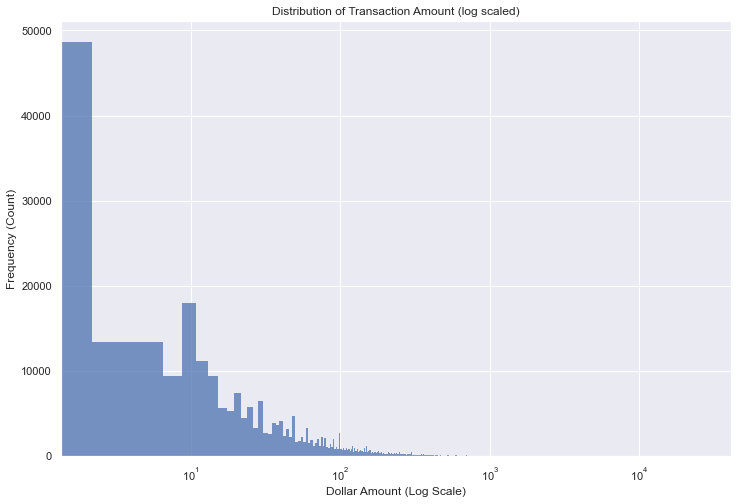

In [6]:
## Feature Variable Analysis

# Basic statistics
print(df['Amount'].describe())

# Distribution
sns.histplot(data=df, x='Amount').set(xscale="log")
plt.xlabel("Dollar Amount (Log Scale)")
plt.ylabel("Frequency (Count)")
plt.title("Distribution of Transaction Amount (log scaled)")
plt.show()

# 3. Data Cleaning

There are  0 null/na values in the dataset


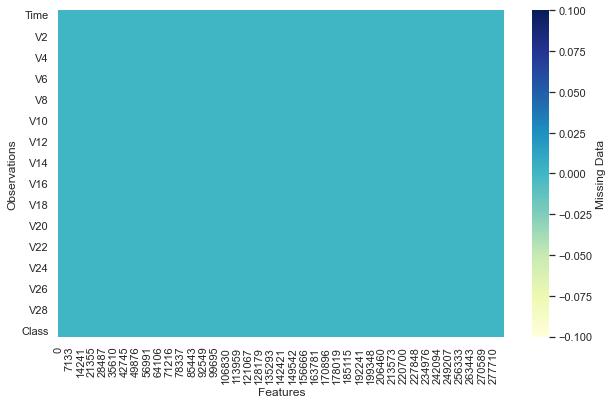

In [45]:
## Missing Values
print("There are %2d null/na values in the dataset" % df.isna().sum().sum())
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

**Takeaway:** As the plot shows above, we have no missing values given the pre-processing done prior.

**Note**:
With most predictors transformed, there will be little chance for any outliers in the data points for V1, V2, ..., V28. So, we will only examine Amount as the only meaningful numeric feature.

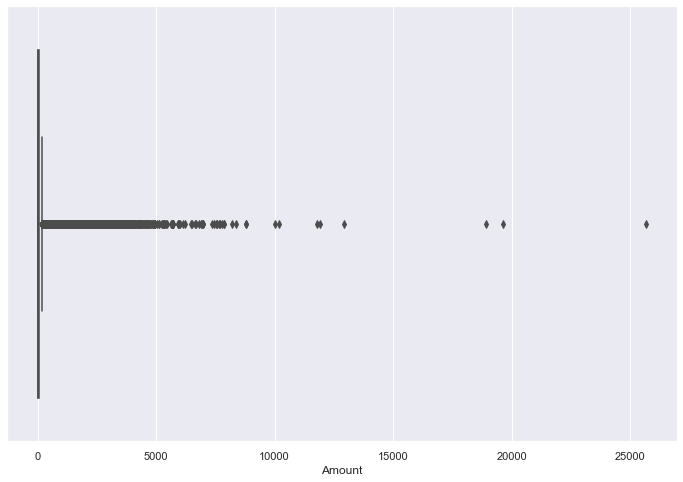

In [8]:
## Outliers
sns.boxplot(data=df, x='Amount')
plt.show()

**Takeaway:** From the boxplot below, we can observe a non-negligible number of outliers on the upper end of the distribution. It would denote transactions with high amounts in the order of thousands of dollars. We would assess the effect of this skewed distribution when building the predictive models in terms of feature transformation or selecting models robust to such feature types.

In [9]:
## Duplicate Observations

# No. of duplicate rows
df.duplicated().value_counts()

False    283726
True       1081
dtype: int64

**Takeaway:** A quick check reveals 1081 duplicate rows, so we proceed in removing them from the dataset.

In [10]:
# Remove all of them
df.drop_duplicates(keep='first', inplace=True)

# 4. Correlation Analysis

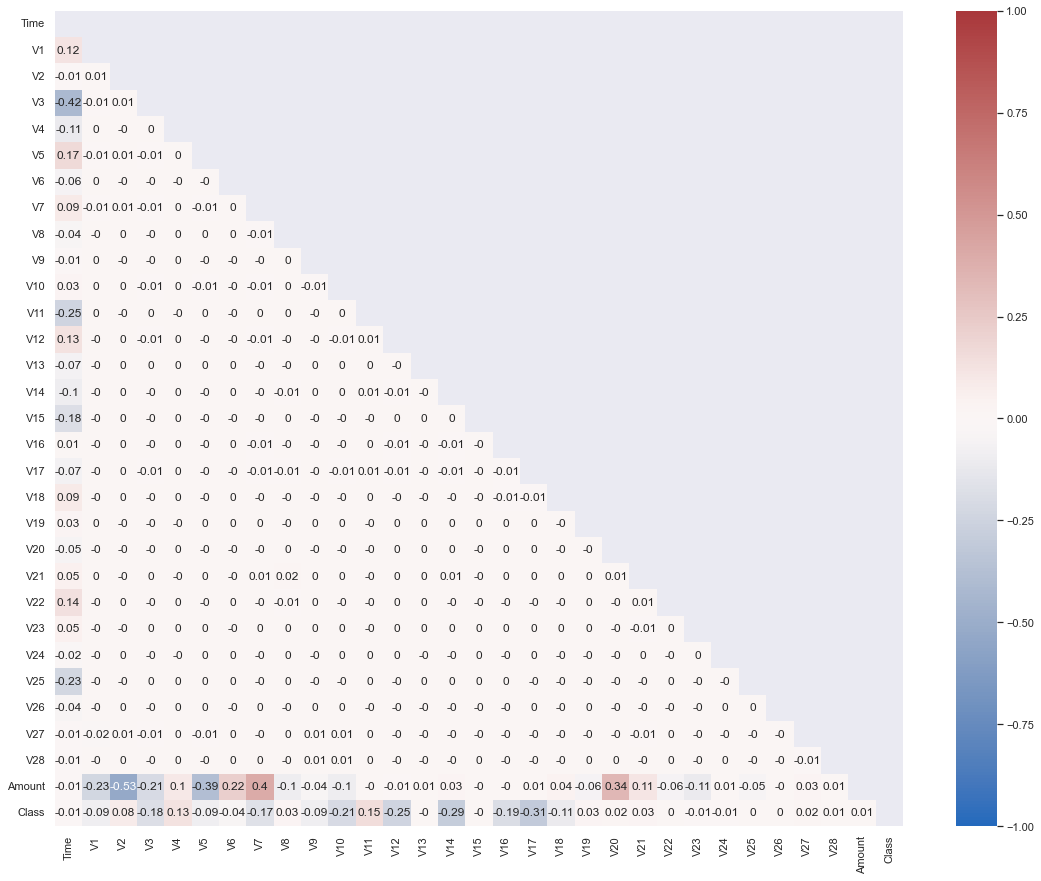

In [11]:
# Correlation Matrix
f = plt.figure(figsize=(19, 15))
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, 
            center=0, cmap='vlag', mask=mask)
plt.show()

**Takeaway:** From the correlation matrix plotted, we can observe very few correlated variables as we would expect after the feature transformation. The two meaningful features, are Time and Amount, have some relative correlation with some variables with coefficients approximating 0.4. With such low values, it would be pretty challenging to imply a correlation between any of them with any certainty. It also indicates that there would be a very low incidence of any colinearity within our data

**Note:**  The code below filters those pairs with correlation coefficients above 0.2 as a threshold. As noted above, those values give very little to no confidence in any solid correlated relationship between variables as none even cross the 0.5 mark.

In [12]:
# Strongest relationship: Filtering those with some signigicant correlation coefficients
matrix = df.corr()
matrix = matrix.unstack()
matrix = matrix[abs(matrix) >= 0.2]

print(matrix)

Time    Time      1.000000
        V3       -0.422054
        V11      -0.248536
        V25      -0.233262
V1      V1        1.000000
        Amount   -0.230105
V2      V2        1.000000
        Amount   -0.533428
V3      Time     -0.422054
        V3        1.000000
        Amount   -0.212410
V4      V4        1.000000
V5      V5        1.000000
        Amount   -0.387685
V6      V6        1.000000
        Amount    0.216389
V7      V7        1.000000
        Amount    0.400408
V8      V8        1.000000
V9      V9        1.000000
V10     V10       1.000000
        Class    -0.206971
V11     Time     -0.248536
        V11       1.000000
V12     V12       1.000000
        Class    -0.250711
V13     V13       1.000000
V14     V14       1.000000
        Class    -0.293375
V15     V15       1.000000
V16     V16       1.000000
V17     V17       1.000000
        Class    -0.313498
V18     V18       1.000000
V19     V19       1.000000
V20     V20       1.000000
        Amount    0.340729
V

# 5. Inquiry Exploration

**Note:** In an attempt to answer the first question, we first split our dataset by class types; in other words, fraudulent and non-fraudulent transactions. We then plot the histogram side by side to observe any unusual behavior. In doing so, the non-fraud transactions were heavily right-skewed, making it quite challenging to compare the plots. To solve this issue, we used a logarithmic transformation, making it easier to see and thus, evaluate any similarities and differences.

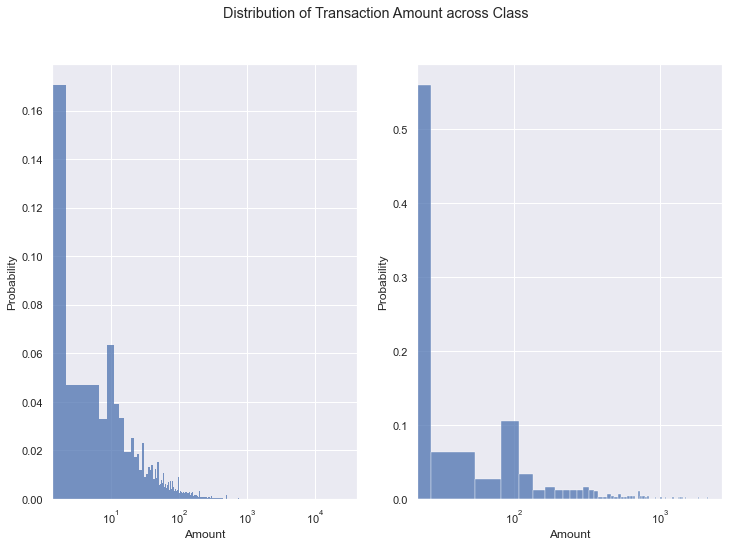

In [13]:
# How does Amount's distribution behaves across classes?

# Splitting data by fraud class
df_no_fraud = df[df['Class'] == 0]
df_fraud = df[df['Class'] == 1]

# Histogram for Amount Distribution per class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Distribution of Transaction Amount across Class')
sns.histplot(ax=ax1, data=df_no_fraud, x='Amount', stat='probability').set(xscale="log")
sns.histplot(ax=ax2, data=df_fraud, x='Amount', stat='probability').set(xscale="log")
plt.show()

**Takeaway:** Before making a note on the plots, we will first explain how to interpret logarithmic scales. In short, log scales show relative values rather than absolute ones. Indeed, 2 minus 1 would be displayed similarly to 9999 minus 9998, given that we are dealing with percentages here. In context, the histograms below would depict the order of growth of transaction value. Both distributions represent a similar trajectory, with most transactions on the lower end of the graph. It stays consistent with the mean value found at USD88, even with max values averaging USD20,000.

**Note:**
We will first create a scatterplot only with the fraud dataset extracted above for the second question.

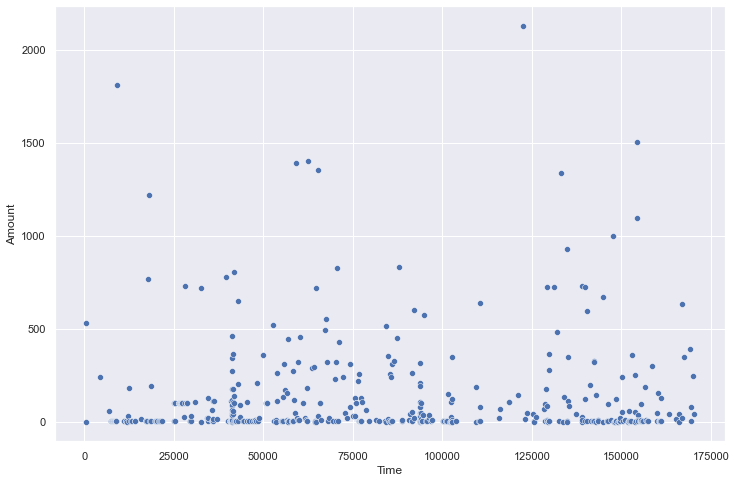

In [14]:
## Are there any noteworthy point in time where fraud occured?
# Scatterplot
sns.scatterplot(data=df_fraud, x='Time', y='Amount')
plt.show()

**Takeaway:** The graph above does not appear that there is a clustering pattern on a time interval. So, we would assume that fraud occurred across time quite randomly. 

# 6. Class Imbalance

**Note:** Our diagnostics observed a stark imbalance between classes of transactions, with fraud only making up 0.2% of all transaction statuses. Given the limited pool of examples to train, it poses an issue in terms of building an effective machine model to predict if there is a fraud. With the minority class being so small, we would expect poor performance on the critical task of detecting fraud transactions. In that vein, we will use different sampling methods (Undersampling & Oversampling) to tackle this problem.

In [15]:
# Splitting features & target variable
X = df.drop(['Class'], axis=1)
y = df['Class']

**Definition:** SMOTE (Synthetic Minority Oversampling Technique) is an oversampling approach to the minority class. In context, it would mean to randomly increase fraud examples by "artificially" replicating to have a more balanced class distribution. Further information [here](https://rikunert.com/smote_explained).

In [16]:
## SMOTE
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (283726, 30)
Shape of X after SMOTE: (566506, 30)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: Class, dtype: float64

**Definition:** Near-Miss Algorithm is an undersampling approach on the majority class. In context, we select examples to keep out of the training set based on the distance of majority class examples to minority class examples. Further information [here](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/).

In [17]:
##Near Miss Algorithm
nr = NearMiss()

X_nmiss, y_nmiss = nr.fit_resample(X, y)

print(f'''Shape of X before NearMiss Algorithm: {X.shape}
Shape of X after NearMiss Algorithm: {X_nmiss.shape}''')

print('\nBalance of positive and negative classes (%):')
y_nmiss.value_counts(normalize=True) * 100

Shape of X before NearMiss Algorithm: (283726, 30)
Shape of X after NearMiss Algorithm: (946, 30)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: Class, dtype: float64

**Note:** With the risk of overfitting with oversampling and the possibility to lose valuable information from undersampling, we will also consider combining both to rebalance the distribution. So, we shall proceed with the combination to offer curve out the risks we identified.

In [18]:
## Combined Random Sampler
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)

# Oversampling minority class
X_over, y_over = over.fit_resample(X, y)

# Comine with under sampling 
X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)
print(f'''Shape of X before Combined Random Sampler: {X.shape}
Shape of X after Combined Random Sampler: {X_combined_sampling.shape}''')

print('\nBalance of positive and negative classes (%):')
y_combined_sampling.value_counts(normalize=True) * 100

Shape of X before Combined Random Sampler: (283726, 30)
Shape of X after Combined Random Sampler: (318658, 30)

Balance of positive and negative classes (%):


0    55.555486
1    44.444514
Name: Class, dtype: float64

In [49]:
# Defined the final features & target
X_final, y_final = X_combined_sampling, y_combined_sampling

# 7. Machine Learning set-up

Under this section, we will explain the procedure of two main splitting approach to estimate our models' performance. 

**Definition:** Often denoted as the most popular by its simplicity, the train-test split is a sampling technique dividing the dataset between training and testing sets. In doing so, the goal would be to have enough (but not too much) in our training set used for the machine learning model to predict the observations in the testing set as accurately as possible. Most would opt for a 70/30 training-testing split, respectively, others 80/20, 60/40, or whichever else works best for the case scenario. Further information [here](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). 

In [50]:
## Training Testing Split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=0.3, 
                                                    random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
skm.average_precision_score(y_test, y_pred)

0.9114202983163333

**Definition:** As the name would suggest, we will engage here in the process of validation to ensure reliability on our model. Cross-Validation is a statistical method applied in various ways to estimate the model's performance. Some examples are **Holdout Method, K-Fold, Stratified K-Fold, Leave-P-Out.**  Further information [here](https://machinelearningmastery.com/k-fold-cross-validation/) and [here](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f).

**Note:** As we already tackled the issue of class imbalance with a combination of under- and over-sampling, we will use the K-Fold cross-validation

In [53]:
## Cross-Validation
scores = cross_val_score(LogisticRegression(), X_final, y_final, 
                        cv=5, scoring='average_precision', 
                        n_jobs=-1, error_score="raise")

print('Average Precision Score: %.3f (%.3f)' % (np.mean(scores), 
                                                np.std(scores)))

Average Precision Score: 0.980 (0.002)


# 8. Dimensionality Reduction

This section will use dimensionality reduction to trim down the number of features we have. Dimensionality reduction encapsulates the techniques reducing the input variables in our training data. In doing so, we hope to have a more straightforward but effective machine learning model structure and avoid any potential case of overfitting. We will be testing three different methods from Linear Algebra: **PCA, SVD, and LDA** on a simple Logistic Regression model and pick the best performing.

#### Note:
PCA (Principal Component Analysis) takes data with m-columns to be projected to a subspace with n-features (n < m) while preserving the crucial information from the original data; in other words, PCA attempts in finding the **principal components (or features)** as its names denotes.  Further information [here](https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/). 

In [23]:
dimred_steps = dict()

In [24]:
##Principal Component Analysis
# Define the pipeline
pca_steps = [('pca', PCA()), 
             ('m', LogisticRegression())]

# Create & Evaluate model
dimred_steps.update({'PCA': pca_steps})

#### Note:
SVD (Singular Value Decomposition) is a process which breaks down a matrix into its constituents elements by factorizing it into three seperate metrices: **M=UΣVᵗ**. 
* M: original matrix
* U: left singular matrix (columns are left singular vectors) containing eigenvectors of matrix MMᵗ
* Σ: a diagonal matrix containing singular (eigen)values
* V: right singular matrix (columns are right singular vectors) containing  eigenvectors of matrix MᵗM.

Further information [here](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/). 

In [25]:
##Singular Value Decomposition
# Define the pipeline
svd_steps = [('svd', TruncatedSVD()), 
             ('m', LogisticRegression())]

# Create & Evaluate model
dimred_steps.update({'SVD': svd_steps})

#### Note:
LDA (Linear Discriminant Analysis) seeks to seperate samples within the training set by class types by finding a linear combination of input variables. The LDA algorithms reposes matrix factorization; a core concept in Linear Algebra. Futher information [here](https://machinelearningmastery.com/linear-discriminant-analysis-for-dimensionality-reduction-in-python/). 

In [26]:
##Linear Discriminant Analysis
# Define the pipeline
lda_steps = [('lda', LinearDiscriminantAnalysis()), 
             ('m', LogisticRegression())]

dimred_steps.update({'LDA': lda_steps})

In [27]:
dimred_steps

{'PCA': [('pca', PCA()), ('m', LogisticRegression())],
 'SVD': [('svd', TruncatedSVD()), ('m', LogisticRegression())],
 'LDA': [('lda', LinearDiscriminantAnalysis()), ('m', LogisticRegression())]}

#### Takeaway:
Though the LDA performed second best, we will opt to use it given that is more stable and focuses on maximizing the separability between the groups; quite important in our classification task.

In [28]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=32)
for name, steps in dimred_steps.items():
    model = Pipeline(steps=steps)
    n_scores = cross_val_score(model, X_train, y_train, 
                               scoring='average_precision', cv=cv, 
                               n_jobs=-1)
    # report performance
    print(name+' - Average Precision Score: %.3f' % (np.mean(n_scores)))

PCA - Average Precision Score: 0.981
SVD - Average Precision Score: 0.539
LDA - Average Precision Score: 0.975


# 9. Machine Learning - Simple Models

#### Note:
Under this section, we will leverage the powerful scikit-learn package to build multiple models with little to no parameter tuning for comparison. To avoid any data leakage, we will only use the cross-validation error on our training dataset.

In [29]:
# Dictionary to store model structures
model_steps = dict()

#### Note:
**Logistic Regression** is a predictive classifier that models a S-shapred curve (Sigmoid function) on the data to label the examples. Further information [here](https://machinelearningmastery.com/logistic-regression-for-machine-learning/).

In [30]:
## Logistic Regression
logreg_steps = [('lda', LinearDiscriminantAnalysis()), 
                ('m', LogisticRegression())]
model_steps.update({'Logistic Regression':logreg_steps})

#### Note:
**k-Nearest Neighbors** is a machine learning model built on Euclidean distance in categorizing the observations. Further information [here](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761#:~:text=Summary-,The%20k%2Dnearest%20neighbors%20(KNN)%20algorithm%20is%20a%20simple,that%20data%20in%20use%20grows.).

In [31]:
## k-Nearest Neighbors
knn_steps = [('lda', LinearDiscriminantAnalysis()),  
             ('m', KNeighborsClassifier(n_neighbors=2))]
model_steps.update({'k-Nearest Neighbors':knn_steps})

#### Note:
**Stochastic Gradient Descent** is an iterative algortihm trying to minimize the model's error rate. Further information [here](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31).

In [32]:
## Stochastic Gradient Descent
sgd_steps = [('lda', LinearDiscriminantAnalysis()),  
             ('m', SGDClassifier())]
model_steps.update({'Stochastic Gradient Descent':sgd_steps})

#### Note:
**Decision Tree** is a type of supervised machine learning algorithm building an actual tree based on splits within the data. [here](https://www.xoriant.com/blog/product-engineering/decision-trees-machine-learning-algorithm.html).

In [33]:
## Decision Tree
tree_steps = [('lda', LinearDiscriminantAnalysis()), 
               ('m', DecisionTreeClassifier())]
model_steps.update({'Decision Tree Classifier':tree_steps})

In [34]:
# Checking the dictionary of models
model_steps

{'Logistic Regression': [('lda', LinearDiscriminantAnalysis()),
  ('m', LogisticRegression())],
 'k-Nearest Neighbors': [('lda', LinearDiscriminantAnalysis()),
  ('m', KNeighborsClassifier(n_neighbors=2))],
 'Stochastic Gradient Descent': [('lda', LinearDiscriminantAnalysis()),
  ('m', SGDClassifier())],
 'Decision Tree Classifier': [('lda', LinearDiscriminantAnalysis()),
  ('m', DecisionTreeClassifier())]}

In [35]:
# Cross-Validation & model building
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
for name, model_steps in model_steps.items():
    model = Pipeline(steps=model_steps)
    n_scores = cross_val_score(model, X_train, y_train, 
                               scoring='average_precision', cv=cv, 
                               n_jobs=-1)
    # report performance
    print(name+' - Average Precision Score: %.3f (%.3f)' % (np.mean(n_scores), 
                                                            np.std(n_scores)))

Logistic Regression - Average Precision Score: 0.975 (0.000)
k-Nearest Neighbors - Average Precision Score: 0.996 (0.000)
Stochastic Gradient Descent - Average Precision Score: 0.975 (0.001)
Decision Tree Classifier - Average Precision Score: 0.996 (0.001)


### 9. Machine Learning - Ensemble Methods

#### Note:
In this section, we will extend our work in mahcine learning to incorporate ensemble methods. We generated simple models and compared the scores which appear to be quite satisfactory with the lowest at 0.974 for the Average Precision Score. However, we may want more stability and less variation in our predictive algorithm; it is where ensemble techniques come in. Most often, they act as a superposer of multiple models throughout a variety of ways and thus, bolster their predictive power. Further Information [here](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/). 

In [36]:
# Dictionary to store ensemble model structures
ensemble_models = dict()

#### Note:
Random Forest build onto the logic of decision trees by agglomerating multiple trees and obtaining a given prediction from majority voting; in other words, it is a Decision Tree times n (number of trees). Further information [here](https://towardsdatascience.com/understanding-random-forest-58381e0602d2).

In [37]:
## Random Forest
rf_steps = [('lda', LinearDiscriminantAnalysis()), 
               ('m', RandomForestClassifier(n_estimators=10))]
ensemble_models.update({'Random Forest':rf_steps})

#### Note:
Stochastic Gradient Boosting are part of the more sophisticated ensemble techniques learning on previous models' errors and build a sequential improvement process. Further information [here](https://towardsdatascience.com/understanding-random-forest-58381e0602d2).

In [38]:
## Stochastic Gradient Boosting
boost_steps = [('lda', LinearDiscriminantAnalysis()), 
               ('m', GradientBoostingClassifier())]
ensemble_models.update({'Stochastic Gradient Boosting':boost_steps})

#### Note:
Stacking Classifier creates a meta-model bases on individual models in order to improve performance, though not always so in all cases. Further information [here](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/).

In [39]:
## StackingClassifier
estimators = [
    ('logreg', LogisticRegression()),
    ('knn', KNeighborsClassifier(n_neighbors=2)),
    ('sdg', SGDClassifier()),
     
]
stack_steps = [('lda', LinearDiscriminantAnalysis()), 
               ('m', StackingClassifier(estimators=estimators, 
                         final_estimator=DecisionTreeClassifier()))]
ensemble_models.update({'StackingClassifier':stack_steps})

In [40]:
# Cross-Validation & model building
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
for name, model_steps in ensemble_models.items():
    model = Pipeline(steps=model_steps)
    n_scores = cross_val_score(model, X_train, y_train, 
                               scoring='average_precision', cv=cv, 
                               n_jobs=-1)
    # report performance
    print(name+' - Average Precision Score: %.3f (%.3f)' % (np.mean(n_scores), 
                                                            np.std(n_scores)))

Random Forest - Average Precision Score: 0.996 (0.000)
Stochastic Gradient Boosting - Average Precision Score: 0.990 (0.001)
StackingClassifier - Average Precision Score: 0.887 (0.018)


#### Takeaway:
Based on the numbers obtained, the Random Forest model was on par with the two best individual models, that are K-Nearest Neighbors and Decision Tree. The Stochastic Gradient Boosting outperformed Logistic Regression and Stochastic Gradient Descent. In contrast, the staking model was aorse than all of the above. Moving forward, we will evaluate the performance of the top 3 using the testing set.

### 10. Model Performance Evaluation

### Note:
Under this section, we will build on everything we've done throughout this notebook and identify the model which performs best given a set of tools. In the problem description, the recommendation was on the AUPRC (Area Under the Precision-Recall Curve) given the class imbalance. 

In [41]:
# The top 3 models
models_top_3 = {}
models_top_3.update({'k-Nearest Neighbors':knn_steps})
models_top_3.update({'Decision Tree Classifier':tree_steps})
models_top_3.update({'Random Forest':rf_steps})

#### Definition:
AUPRC (Area Under the Precision-Recall Curve) focuses on finding the positive examples; in other words, the fraudulent transactions in our case. Read more [here](https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/).

In [42]:
# Cross Validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
for name, model_steps in models_top_3.items():
    model = Pipeline(steps=model_steps)
    n_scores = cross_val_score(model, X_test, y_test, 
                               scoring='average_precision', cv=cv, 
                               n_jobs=-1)
    # report performance
    print(name+' - Average Precision Score: %.4f (%.4f)' % (np.mean(n_scores), 
                                                            np.std(n_scores)))

k-Nearest Neighbors - Average Precision Score: 0.9946 (0.0010)
Decision Tree Classifier - Average Precision Score: 0.9948 (0.0008)
Random Forest - Average Precision Score: 0.9946 (0.0010)


### Conclusion:
Though k-Nearest Neighbors and Random Forest had the highest average AUPRC, the Decision Tree Classifier had the lowest standard deviation. It would imply that this model is more stable while predicting more than 99% of all fraudulent cases given. So, we will present the Decision Tree Classifier as our final model